In [108]:
# !pip install scikit-image numpy matplotlib pytesseract natsort sspipe
# !pip install pyvips

In [110]:
from pathlib import Path
from functools import reduce
import csv

import skimage
import pytesseract as tess
import matplotlib.pyplot as plt
import numpy as np

import pyvips

from skimage import io, data, color, filters, exposure, morphology, util

from natsort import natsorted

from sspipe import p, px
# From sspipe's doc:
#   The whole functionality of this library is exposed by two objects 
#   p (as a wrapper for functions to be called on the piped object) and 
#   px (as a placeholder for piped object).

In [186]:
img_paths = Path('/run/media/luce/7AFA92DC327E1C3A/DATA/ScanNEW/') | px.glob('**/*.jpg') | p(natsorted)
len(img_paths)
# !pip install natsort
i = 5

In [266]:
image_path = img_paths[i]
# i += 1
# image_path.with_suffix('.row.csv')

# SHOULD_VIS = False

PosixPath('/run/media/luce/7AFA92DC327E1C3A/DATA/ScanNEW/New folder/Untitled-17.row.csv')

In [205]:
def show_image(image:np.ndarray , title:str ='Image', cmap='gray', imsize=(20,20), plt=plt, force_vis=False) -> None:
    if not SHOULD_VIS and not force_vis:
        return
    plt.figure(figsize=imsize)
    if image[0][0] is not np.ndarray:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')

def show_histogram(image:np.ndarray , title:str ='historgram', thresh:int=None, plt=plt, force_vis=False) -> None:
    if not SHOULD_VIS and not force_vis:
        return 
    plt.hist(image.ravel(), bins=256)
    plt.title(title)
    if thresh is not None:
        plt.axvline(thresh, color='r') 

## Load image

In [206]:
# imgnp = io.imread(image_path)

In [207]:
image = pyvips.Image.new_from_file(str(image_path), access="sequential")#, shrink=4)
print(image)
image_bw = image.sRGB2scRGB().scRGB2BW(depth=8)
print(image_bw)
mem_img = image_bw.write_to_memory() 
# imgnp = np.frombuffer(mem_img, dtype=np.uint8).reshape(image_bw.height, image_bw.width, 3)  # sRGB 
imgnp = np.frombuffer(mem_img, dtype=np.uint8).reshape(image_bw.height, image_bw.width)  # BW

<pyvips.Image 5100x8400 uchar, 3 bands, srgb>
<pyvips.Image 5100x8400 uchar, 1 bands, b-w>


In [208]:
# show_image(imgnp, force_vis=True)

## Cut-out the top part

In [209]:
# top = util.img_as_ubyte(imgnp[100:1600, 500:-500]).copy()
top = imgnp[100:1600, 500:-500].copy()
top[1000:, 1000:] = np.percentile(top, 97)
show_image(top);

## Cut-out right half

(1500, 4100)
(1300, 1400)


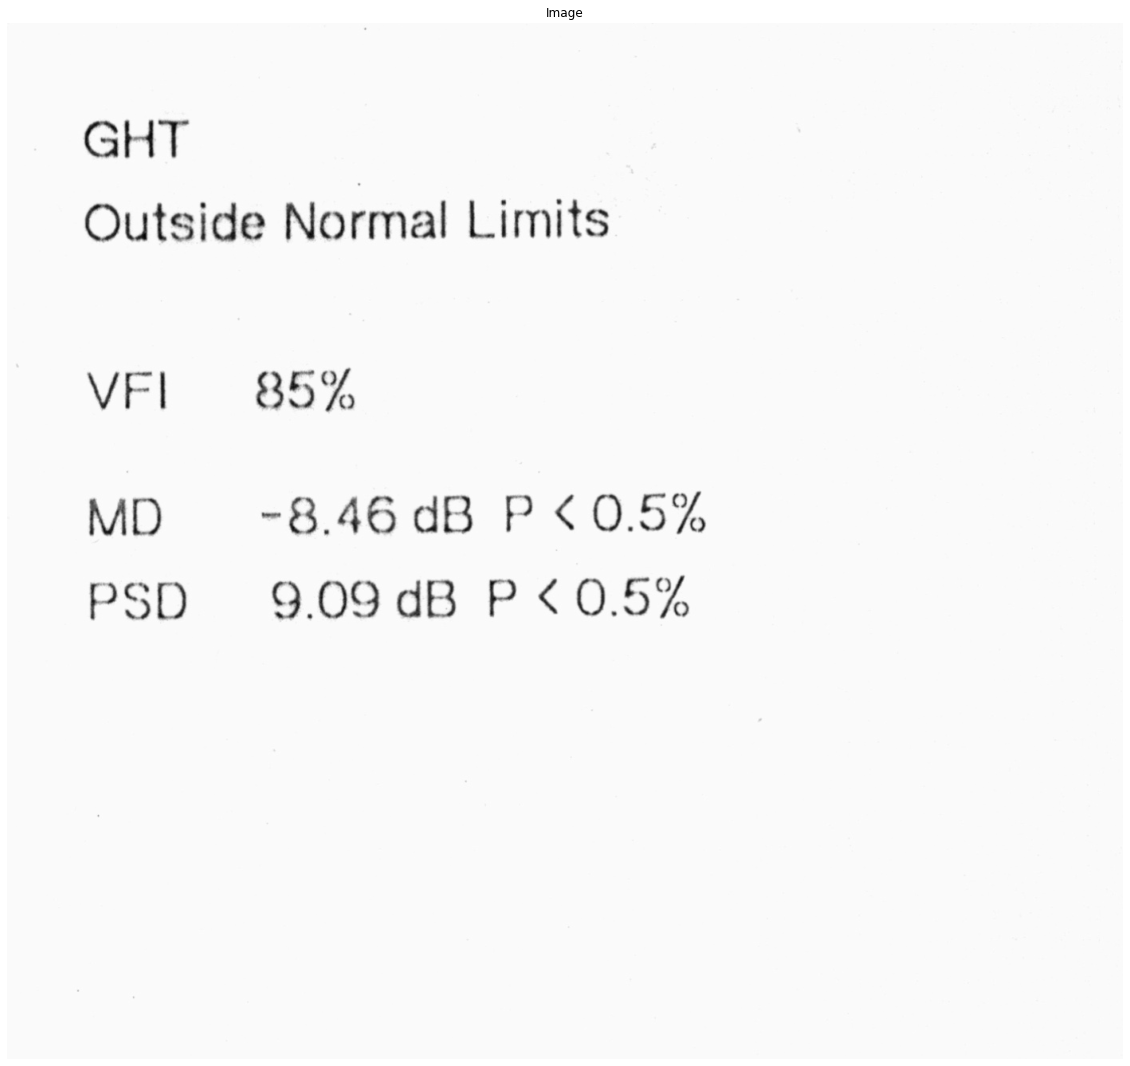

In [241]:
right = imgnp[3000:4300, 3400:-300].copy()
show_image(right, force_vis=True)
print(top.shape, right.shape, sep='\n')

## Convert to gray-Scale

In [210]:
## imgray = skimage.color.rgb2gray(image)
# topgray = color.rgb2gray(top)
# topgray = util.img_as_ubyte(topgray)
topgray = top
show_image(topgray);

## Adjust the image using *local histogram equalization*

In [211]:
def plot_hist(image, ax_hist, bins=256, force=False):
    """Plot an image along with its histogram and cumulative histogram.
    """
    if not SHOULD_VIS and not force:
        return
    ax_hist = plt
    ax_cdf = ax_hist.twinx()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = util.dtype.dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_hist, ax_cdf

# fig, ax = plt.subplots()
ax = None
plot_hist(topgray, ax);

## Remove small dots using an *opening* operation

In [212]:
# topop = morphology.opening(topgray, morphology.square(2))
# show_image(topop);

In [213]:
ps = np.percentile(topgray, (3, 8))
topadj = exposure.rescale_intensity(topgray, in_range=tuple(ps))
# top_ajd = skimage.exposure.equalize_adapthist(topg)

show_image(topadj)

## Thresholding

In [214]:
otsu_filter = filters.threshold_otsu(topadj)
topmono = topadj > (otsu_filter)
show_image(topmono);

In [215]:
topmonoopen = morphology.binary_opening(topmono, morphology.square(3))
show_image(topmonoopen);

## Add a black bar beore `Age` 
It's to force tesseract seperate `RX` from `Age`.

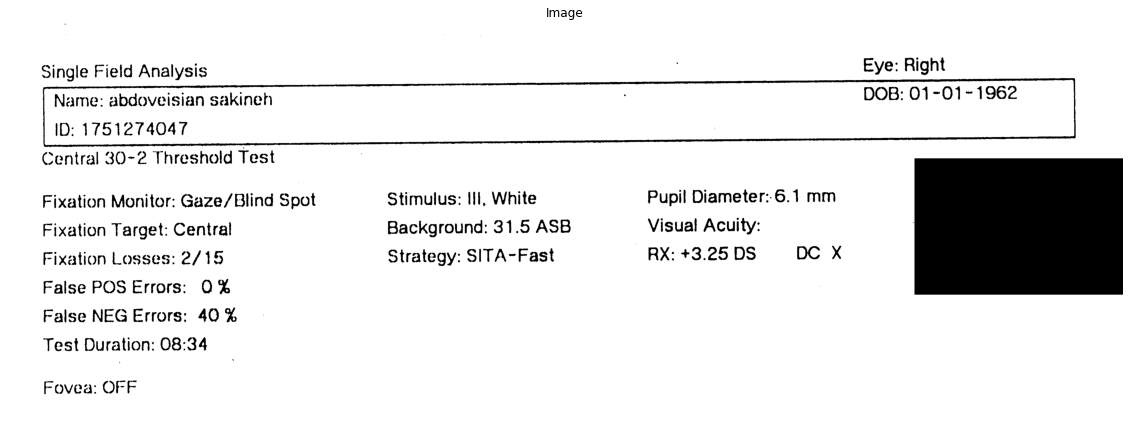

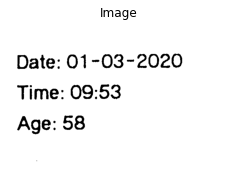

In [216]:
mask = np.ones(topmonoopen.shape, dtype=bool)
x, y = topmonoopen.shape
left = 20
# right = 800
xl, xr = x // 3, 2 * x // 3
yl = 9 * y // 11 - left
mask[xl:xr, yl:] = False
show_image(mask & topmonoopen, force_vis=True);
show_image(topmonoopen[xl:xr, yl:], imsize=(4,4), force_vis=True)

In [217]:
ocr = lambda img: tess.image_to_string(img, config='--oem 2 --psm 11')
ocr_str = ocr(topmonoopen & mask) + '\n' + ocr(topmonoopen[xl:xr, yl:])

In [218]:
print(ocr_str)

Single Field Analysis

Eye: Right

DOB: 01-01-1962

Name: abdoveisian sakineh

ID: 1751274047

Central 30-2 Threshold Test

Fixation Monitor: Gaze/Blind Spot

Stimulus: Ill, White

Pupil Diameter::6.1 mm

Visual Acuity:

Fixation Target: Central

Background: 31.5 ASB

Fixation Losses: 2/15

Strategy: SITA-Fast

RX: +3.25 DS

DC X

False POS Errors: 0%

False NEG Errors: 40 %

Test Duraﬁon: 08:34

Fovea: OFF

Date: 01-03-2020

Time: 09:53

Age: 58



In [219]:
ocr_list = []
for kv_str in filter(lambda x: x, ocr_str.splitlines()):
    l = list(map(lambda s: s.strip(' ,.\t\n'), kv_str.split(':', 1)))
    if len(l) == 1:
        l.append('')
    assert len(l) == 2
    if not (l[1]) and len(l[0]) <= 5:
        ocr_list[-1][1] = f'{ocr_list[-1][1]} {l[0]}'.strip()
    else:
        ocr_list.append(l)
ocr_list

[['Single Field Analysis', ''],
 ['Eye', 'Right'],
 ['DOB', '01-01-1962'],
 ['Name', 'abdoveisian sakineh'],
 ['ID', '1751274047'],
 ['Central 30-2 Threshold Test', ''],
 ['Fixation Monitor', 'Gaze/Blind Spot'],
 ['Stimulus', 'Ill, White'],
 ['Pupil Diameter', ':6.1 mm'],
 ['Visual Acuity', ''],
 ['Fixation Target', 'Central'],
 ['Background', '31.5 ASB'],
 ['Fixation Losses', '2/15'],
 ['Strategy', 'SITA-Fast'],
 ['RX', '+3.25 DS DC X'],
 ['False POS Errors', '0%'],
 ['False NEG Errors', '40 %'],
 ['Test Duraﬁon', '08:34'],
 ['Fovea', 'OFF'],
 ['Date', '01-03-2020'],
 ['Time', '09:53'],
 ['Age', '58']]

In [220]:
with open('res1.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    keys, values = zip(*ocr_dict) #  python's unzip()
    writer.writerow(keys)
    writer.writerow(values)
    
with open('res2.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['Key', 'Value'])
    writer.writerows(ocr_list)